# Mise en situation

Vous êtes une jeune équipe de diplômés et vous voulez créer votre propre entreprise de fintech. Vous savez que la compagnie Crystal Dawn Private Qants essaie depuis des années de développer une stratégie de gestion de portefeuille efficace. 

Malheureusement une épidémie de *Lukehead Byus* a frappé leurs analystes avant qu'ils puissent livrer leur solution. Forts de cette information, vous ne laissez pas passer cette opportunité de leur vendre votre propre stratégie.

Votre espion qui évolue au sein de Crystal Dawn et qui a miraculeusement échappé à l'épidémie a réussi à vous obtenir un entretien vendredi prochain. 

Il vous fournit les exigeances de la compagnie qui doivent impérativement être respectées sans quoi vous n'aurez aucune chance de décrocher le contrat:

- Le portefeuille doit être **long-only** et toujours comporter au moins 120 titres - $\sum (w_i\geq.0000001) \geq 120$.
- Vous ne pouvez investir que dans les 304 titres représentatifs du S&P 500 fournis avec le présent notebook.
- La stratégie doit être 'aveugle', il est interdit d'utiliser de l'information implicite liée au futur lorsque vous roulez votre stratégie sur les données historiques. (Vous risquez d'attraper le *Luckehead Byus*.)
- Vous pouvez rebalancer votre portefeuille chaque jour.

La compagnie à qui vous essayez de vendre votre stratégie va tenir des mini conférences le samedi matin ainsi que le dimanche. Assurez-vous d'y être pour récolter des informations supplémentaires sur ce à quoi elle sera attentive lors de votre présentation.

Note: *Se retirer complètement pendant une période est autorisé ($\sum w_i=0$) si le signal de retrait est produit algorithmiquement et non la conséquence d'une décision arbitraire, gare au Luckehead Byus !*

## Livrables
Pour passer l'entretien préliminaire vous devez fournir:
- Un notebook écrit en Python ou R fonctionnel avec certaines cellules de code obligatoires.
- Un fichier submission.csv contenant la pondération de votre portefeuille (le montant investi dans chaque titre) sur l'intervalle 2000-2015 avec un format correspondant au fichier `sample_submission.csv` 

Si vous passez l'entretien préliminaire, vous devrez préparer un rapide pitch de 6 minutes pour convaincre votre client potentiel de la qualité de votre stratégie. Crystal Dawn Private Quants vous demande d'absolument présenter votre stratégie en respectant le format suivant:

- Diapo 1: intuition, processus méthodologique (données, efforts pour ne pas overfitter, contraintes d'optimisation et fonction objectif)
- Diapo 2: tableau synthèse des différentes métriques, courbes de valeur ajoutée, pires rabattement, allocation sectorielle
- Diapo 3: calendrier de performance en valeur ajoutée
- Diapo 4: vue récente du portefeuille (nombre de titre, overweight,underweight…)

Vous saurez mardi soir si vous avez passé cet entretien préliminaire et êtes sélectionnés pour l'entretien final.

In [1]:
!pip install pandas seaborn matplotlib numpy statsmodels scikit-learn tqdm getFamaFrenchFactors bs4 html5lib lxml cvxopt cvxpy


In [2]:
import pandas as pd 
import numpy as np
import cvxpy as cp
import sklearn as sk

import matplotlib.pyplot as plt
from tqdm import tqdm


## Loading data

In [3]:
ROOT='./kaggle/input/dt23-test/'


In [4]:
adjusted_close = pd.read_csv(ROOT+'series/adjusted_close.csv',index_col=0)
adjusted_close.index = pd.to_datetime(adjusted_close.index)
# Uncomment the following line to test the notebook on a reduced number of 
# products that span the entire makespan
# adjusted_close = adjusted_close.dropna(axis=1).iloc[:,:20]

adjusted_close.tail()


,adjusted_close_CSCO,adjusted_close_ISRG,adjusted_close_TPR,adjusted_close_DVN,adjusted_close_MRO,adjusted_close_BA,adjusted_close_GILD,adjusted_close_MDT,adjusted_close_V,adjusted_close_A,...,adjusted_close_CI,adjusted_close_BALL,adjusted_close_JNJ,adjusted_close_DOV,adjusted_close_CRM,adjusted_close_PGR,adjusted_close_WAT,adjusted_close_BWA,adjusted_close_BLK,adjusted_close_PPL
timestamp,,,,,,,,,,,,,,,,,,,,,
1999-11-05,25.314724,NaN,NaN,12.461711,4.853413,28.456285,1.094115,25.148404,NaN,NaN,...,23.849731,1.959694,28.722943,18.832176,NaN,4.541630,22.595,3.439710,9.844385,4.417924
1999-11-04,24.128958,NaN,NaN,12.706442,4.915478,27.859031,1.098568,25.022264,NaN,NaN,...,23.090627,1.953749,28.668492,18.617589,NaN,4.452288,23.345,3.434614,9.338102,4.417924
1999-11-03,24.646007,NaN,NaN,12.624865,4.920797,27.775543,1.168869,25.022264,NaN,NaN,...,22.712518,1.987930,28.396237,18.669090,NaN,4.413589,23.250,3.434614,9.219344,4.459399
1999-11-02,25.335406,NaN,NaN,12.686863,5.075071,27.859031,1.148247,24.066253,NaN,NaN,...,22.695200,1.969106,27.906177,18.480253,NaN,4.440344,23.405,3.423573,9.219344,4.479307
1999-11-01,25.121693,NaN,NaN,12.686863,5.197426,28.661792,1.482176,23.654637,NaN,NaN,...,21.179877,1.984462,28.614041,18.025328,NaN,4.407378,25.280,3.387052,9.219344,4.489261


In [5]:
high = pd.read_csv(ROOT+'series/high.csv',index_col=0)
high.index = pd.to_datetime(high.index)
low = pd.read_csv(ROOT+'series/low.csv',index_col=0)
low.index = pd.to_datetime(low.index)
stock_names = [c.replace('adjusted_close_', '') for c in adjusted_close.columns]
combined = high.merge(low, left_index=True, right_index=True, how='inner')
combined = combined.merge(adjusted_close, left_index=True, right_index=True, how='inner')
cutoff_date = pd.to_datetime('01-01-2016')
filtered_df = combined[combined.index <= cutoff_date]

In [6]:
from scipy.stats import stats

def remove_outliers_stock(stock_to_clean, threshold=2):
    for feature in stock_to_clean.keys():
        z_scores = stats.zscore(stock_to_clean[feature])
        mean = stock_to_clean[feature].mean()
        stock_to_clean.loc[abs(z_scores) > threshold, feature] = mean
    return stock_to_clean
filtered_df = remove_outliers_stock(filtered_df)

C:\Users\hamzp\AppData\Local\Temp\ipykernel_5692\3564846370.py:5: DeprecationWarning: Please use `zscore` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  z_scores = stats.zscore(stock_to_clean[feature])


In [7]:
filtered_df = filtered_df.iloc[::-1]
for c in stock_names:
    filtered_df[f"ri_{c}"] = filtered_df[f"adjusted_close_{c}"].pct_change()
    filtered_df[f"ri_{c}"].iloc[0] = 0

for c in stock_names:
    filtered_df[f"high-low_{c}"] = filtered_df[f"high_{c}"] - filtered_df[f"low_{c}"]

for c in stock_names:
    filtered_df[f"rolling_diff_year_{c}"] = filtered_df[f"adjusted_close_{c}"].diff(periods=365)
    filtered_df[f"rolling_diff_month_{c}"] = filtered_df[f"adjusted_close_{c}"].diff(periods=30)
    filtered_df.loc[filtered_df.index[:365], f"rolling_diff_year_{c}"] = filtered_df[f"adjusted_close_{c}"] - filtered_df[f"adjusted_close_{c}"].iloc[0]
    filtered_df.loc[filtered_df.index[:30], f"rolling_diff_month_{c}"] = filtered_df[f"adjusted_close_{c}"] - filtered_df[f"adjusted_close_{c}"].iloc[0]

for c in stock_names:
    var_mean = filtered_df[f"rolling_diff_month_{c}"].iloc[0]
    def rolling_mean(x):
        return x*0.05 + var_mean*0.95

    filtered_df[f"rolling_avg_diff_month_{c}"] = filtered_df[f"rolling_diff_month_{c}"].apply(rolling_mean)
for c in stock_names:
    var_mean = filtered_df[f"high-low_{c}"].iloc[0]
    filtered_df[f"rolling_avg_low_high_{c}"] = filtered_df[f"high-low_{c}"].apply(rolling_mean)

filtered_df.tail()

C:\Users\hamzp\AppData\Local\Temp\ipykernel_5692\4117948061.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  filtered_df[f"ri_{c}"] = filtered_df[f"adjusted_close_{c}"].pct_change()
C:\Users\hamzp\AppData\Local\Temp\ipykernel_5692\4117948061.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  filtered_df[f"ri_{c}"] = filtered_df[f"adjusted_close_{c}"].pct_change()
C:\Users\hamzp\AppData\Local\Temp\ipykernel_5692\4117948061.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

,high_CSCO,high_ISRG,high_TPR,high_DVN,high_MRO,high_BA,high_GILD,high_MDT,high_V,high_A,...,rolling_avg_low_high_CI,rolling_avg_low_high_BALL,rolling_avg_low_high_JNJ,rolling_avg_low_high_DOV,rolling_avg_low_high_CRM,rolling_avg_low_high_PGR,rolling_avg_low_high_WAT,rolling_avg_low_high_BWA,rolling_avg_low_high_BLK,rolling_avg_low_high_PPL
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-24,27.5500,549.00,33.22,33.47,14.1100,72.514697,58.448357,49.27691,78.71,42.26,...,1.87388,1.181781,1.079892,1.2825,NaN,1.0845,3.22851,0.681500,0.63600,0.3770
2015-12-28,27.3700,549.50,33.05,32.48,13.5700,72.514697,58.448357,49.27691,78.65,42.08,...,1.87388,1.181781,2.707615,1.2775,NaN,1.0775,3.22851,0.698500,0.74850,0.3750
2015-12-29,27.8200,556.60,33.23,32.84,13.4400,72.514697,58.448357,49.27691,79.39,42.48,...,1.87388,1.181781,1.079892,1.3245,NaN,1.0865,3.22851,0.700000,0.60955,0.3730
2015-12-30,27.7700,555.63,33.02,32.53,13.0664,72.514697,58.448357,49.27691,79.19,42.38,...,1.87388,1.181781,1.079892,1.2905,NaN,1.0765,3.22851,0.680625,0.55000,0.3765
2015-12-31,27.4499,552.88,32.90,32.20,12.6600,72.514697,58.448357,49.27691,78.80,42.35,...,1.87388,1.181781,2.715115,1.2955,NaN,1.0845,3.22851,0.699500,0.74900,0.3930


In [8]:
# for c in stock_names:
#     var_mean = normalized_df[f"rolling_diff_month_{c}"].iloc[0]
#     def rolling_mean(x):
#         return x*0.05 + var_mean*0.95
#     
#     normalized_df[f"rolling_avg_diff_month_{c}"] = normalized_df[f"rolling_diff_month_{c}"].apply(rolling_mean)
# for c in stock_names:
#     var_mean = normalized_df[f"high-low_{c}"].iloc[0]
#     normalized_df[f"rolling_avg_low_high_{c}"] = normalized_df[f"high-low_{c}"].apply(rolling_mean)

In [9]:
# import getFamaFrenchFactors as gff
# factors = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
# factors.index = pd.to_datetime(factors.date_ff_factors)
# factors.index = factors.index - pd.DateOffset(months=1)

# factors_resampled = factors.resample('D').ffill()
# combined_with_factors = normalized_df.merge(factors_resampled, left_index=True, right_index=True, how='left')
# combined_with_factors.head()

In [10]:
# combined_with_factors.to_csv("normalised_with_factors.csv")

In [11]:
factors = pd.read_csv('F-F_Research_Data_Factors_daily.CSV')
factors = factors.rename(columns={'Unnamed: 0': 'Timestamp'})
factors['Timestamp'] = pd.to_datetime(factors['Timestamp'], format='%Y%m%d')
factors.set_index('Timestamp', inplace=True)
factors

,Mkt-RF,SMB,HML,RF
Timestamp,,,,
1926-07-01,0.10,-0.25,-0.27,0.009
1926-07-02,0.45,-0.33,-0.06,0.009
1926-07-06,0.17,0.30,-0.39,0.009
1926-07-07,0.09,-0.58,0.02,0.009
1926-07-08,0.21,-0.38,0.19,0.009
...,...,...,...,...
2023-08-25,0.65,-0.07,-0.58,0.020
2023-08-28,0.63,-0.01,0.41,0.020
2023-08-29,1.50,0.01,-0.11,0.020


In [12]:
from sklearn.preprocessing import MinMaxScaler

filtered_df = filtered_df.merge(factors, left_index=True, right_index=True, how='inner')
scaler = MinMaxScaler()
normalized_df = pd.DataFrame(scaler.fit_transform(filtered_df), columns=filtered_df.columns, index=filtered_df.index)
normalized_df

C:\Users\hamzp\miniconda3\envs\Desjardins-challenge\Lib\site-packages\sklearn\preprocessing\_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\hamzp\miniconda3\envs\Desjardins-challenge\Lib\site-packages\sklearn\preprocessing\_data.py:481: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


,high_CSCO,high_ISRG,high_TPR,high_DVN,high_MRO,high_BA,high_GILD,high_MDT,high_V,high_A,...,rolling_avg_low_high_CRM,rolling_avg_low_high_PGR,rolling_avg_low_high_WAT,rolling_avg_low_high_BWA,rolling_avg_low_high_BLK,rolling_avg_low_high_PPL,Mkt-RF,SMB,HML,RF
1999-11-01,0.326450,NaN,NaN,0.120603,0.263240,0.176332,0.481073,0.180586,NaN,NaN,...,NaN,0.077567,0.504638,0.490202,0.486159,0.486257,0.422167,0.674144,0.461704,0.653846
1999-11-02,0.326450,NaN,NaN,0.120603,0.265265,0.165041,0.311775,0.225673,NaN,NaN,...,NaN,0.158175,0.511975,0.491840,0.486667,0.498417,0.424631,0.561983,0.545847,0.653846
1999-11-03,0.326450,NaN,NaN,0.128708,0.248598,0.169015,0.327420,0.222779,NaN,NaN,...,NaN,0.087452,0.502023,0.486788,0.485701,0.494741,0.474877,0.676505,0.396980,0.653846
1999-11-04,0.326450,NaN,NaN,0.118496,0.238941,0.167299,0.306467,0.228807,NaN,NaN,...,NaN,0.153612,0.490385,0.487607,0.486820,0.491347,0.473399,0.528926,0.421791,0.653846
1999-11-05,0.326450,NaN,NaN,0.118496,0.242835,0.176332,0.264562,0.239174,NaN,NaN,...,NaN,0.192395,0.556842,0.485832,0.487760,0.493044,0.479803,0.499410,0.444444,0.653846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,0.362881,0.922382,0.313644,0.028854,0.022586,0.425426,0.414001,0.497563,0.147232,0.206337,...,NaN,0.023574,0.490892,0.487880,0.499681,0.484561,0.435468,0.585596,0.470334,0.000000
2015-12-28,0.359319,0.923228,0.311134,0.012806,0.014174,0.425426,0.414001,0.497563,0.146976,0.205144,...,NaN,0.012928,0.490892,0.492523,0.505400,0.483429,0.427094,0.495868,0.432578,0.000000
2015-12-29,0.368223,0.935237,0.313792,0.018642,0.012150,0.425426,0.414001,0.497563,0.150132,0.207795,...,NaN,0.026616,0.490892,0.492933,0.498336,0.482298,0.492611,0.563164,0.442287,0.000000
2015-12-30,0.367234,0.933596,0.310691,0.013616,0.006330,0.425426,0.414001,0.497563,0.149279,0.207132,...,NaN,0.011407,0.490892,0.487641,0.495309,0.484278,0.404433,0.531287,0.456311,0.000000


In [13]:
# values = {}
# for stock in stock_names:
#     stock_value = {}
#     name_len = len(stock)
#     for key in normalized_df.keys():
#         if key == 'Mkt-RF' or key == 'SMB' or key == 'HML' or key == 'RF':
#             stock_value[key] = normalized_df[key]
#         elif key[-name_len:] == stock:
#             stock_value[key[:-(name_len+1)]] = normalized_df[key]
#     values[stock] = pd.DataFrame.from_dict(stock_value)
# values['CSCO'].head()

In [14]:
# test = values['CSCO'].dropna(axis=0)
# test

In [15]:


from sklearn.linear_model import Ridge
import statsmodels.api as sm

def osl_model(y, x):
    # Estime les bêtas par régression
    model = sm.OLS(y, sm.tools.add_constant(x))
    result = model.fit_regularized(method='sqrt_lasso')
    return result

# x = test[['RF', 'Mkt-RF', 'SMB', 'HML', 'rolling_avg_diff_month', 'rolling_avg_low_high']]
# y = test['ri']
#y = (y - y.mean()) / y.std()

def ridge_model(y, x):
    logistic_reg = Ridge(alpha=1.0) 
    if len(x) < 30:
        a = 2
    logistic_reg.fit(x.iloc[:-1], y.iloc[:-1])
    y_pred = logistic_reg.predict(x.tail(1))
    y_pred = pd.DataFrame(y_pred)
    y_pred.index =  [y.index.max()]
    return y_pred

In [16]:
# res = osl_model(y, x)
# coefficients = res.params

In [17]:
#y_pred = coefficients["const"] + coefficients["Mkt-RF"] * x["Mkt-RF"] + coefficients["SMB"] * x["SMB"] + coefficients["HML"] * x["HML"] + coefficients["rolling_avg_diff_month"] * x["rolling_avg_diff_month"] + coefficients["rolling_avg_low_high"] * x["rolling_avg_low_high"]
#y_pred = ridge_model(y, x)
# plt.subplots(1, 1, figsize=(12, 6))
# plt.plot(y[:100], label="y (réel)")
# plt.plot(y_pred[:100], label="y_pred (prédiction)")

# plt.legend()
# plt.show()

In [18]:
# values['ISRG']

In [19]:
def predict(df):
    pred = pd.DataFrame()
    for stock in stock_names:
        init = df[[f'RF', 'Mkt-RF', 'SMB', 'HML', f'ri_{stock}']].dropna(axis=0)
        x = init[[f'RF', f'Mkt-RF', f'SMB', f'HML']]
        y = init[f'ri_{stock}']
        if len(x) < 5:
            y_pred = pd.DataFrame([np.NAN])
        else:
            y_pred = ridge_model(y, x)
        #y_pred = coefficients["const"] + coefficients["Mkt-RF"] * x["Mkt-RF"] + coefficients["SMB"] * x["SMB"] + coefficients["HML"] * x["HML"] + coefficients["rolling_avg_diff_month"] * x["rolling_avg_diff_month"] + coefficients["rolling_avg_low_high"] * x["rolling_avg_low_high"]
        y_pred = y_pred.rename(columns={0: stock})
        pred = pd.concat([pred, y_pred], axis=1, join='outer')
    return pred

In [20]:
# pred = pred[(pred.index >= pd.to_datetime('2000-01-01')) & (pred.index <= pd.to_datetime('2016-01-01'))]
# pred

In [21]:
#pred.to_csv("predictions.csv")

In [22]:

# y = (y - y.mean()) / y.std()
# plt.subplots(1, 1, figsize=(12, 6))
# plt.plot(y, label="y (réel)")
# plt.plot(pred['CSCO'], label="y_pred (prédiction)")

# plt.legend()
# plt.show()

## Pondération du portefeuille
Entrez ici les fonctions que vous utiliserez pour générer les poids de votre portefeuille sur base d'indicateurs tirés des données historiques ou produits avec des méthodes statistiques et/ou d'apprentissage machine.

**Assurez vous que la relation $\sum_{i=1}^{i=302}w_i=1$ est toujours respectée.**

**Prenez gare aux NaNs présents dans le dataset, ils correspondent à des moments ou certains produits ne soit plus soit pas encore disponibles**

Les méthodes que vous voyez ici ne sont pas valides pour la soumission finale:
 - `rand_weights`: sélectionne aléatoirement 5 titres et génère des poids aléatoires.
 - `best_return_fibo`: sélectionne les 10 meilleurs titres en fonction d'une prédiction sur leur rendement et leur assigne des poids proportionnels aux 10 premiers termes de la suite de Fibonacci.
 - `equal_weights`: produit un portefeuille balancé de manière uniforme, reproduit le benchmark

In [23]:
file_path = ROOT+'series/additional_data/SP500_symbol_info.csv'

# Read sectors file
sectors_file = pd.read_csv(file_path)
sectors= {}
for index, row in sectors_file.iterrows():
    key = row['GICS Sector']
    value = row['Symbol']
    if key in sectors:
        sectors[key].append(value)
    else:
        sectors[key] = [value]

bmrk_w = pd.read_csv(ROOT+'series/benchmark/benchmark_weights.csv',index_col=1)
bmrk_w.index = pd.to_datetime(bmrk_w.index)
bmrk_w = bmrk_w.drop('id', axis=1)

In [24]:
def rand_weights(returns,*args,**kwargs):
    """
        Produces random weights for num_to_select assets 
    """
    # The following array will be True for all products i that are available
    product_availability_mask = ~returns.iloc[-1].isna().values
    
    # The following array will contain all the indices i of available products
    available_product_indices = np.nonzero(product_availability_mask)[0]
    
    weights = np.zeros(len(returns.T))
    num_to_select = 125
    
    # Generate unique random indices within the array size
    random_indices = np.random.choice(available_product_indices, num_to_select, replace=False)

    # Create a boolean mask based on the randomly selected indices
    mask = np.zeros(len(weights), dtype=bool)
    mask[random_indices] = True
    rw = np.random.rand(sum(mask))
    rw /= sum(rw)
    weights[mask]=rw
    return pd.Series({"weight_"+a.split('_')[-1]:b for a,b in zip(returns.columns,weights)})

def best_returns_fibo(returns,*args,**kwargs):
    """ 
        Selects the 10 best returns and assigns weights according to a fibonacci ratio 
    """
    weights = np.zeros(len(returns.T))

    # Select the indices of the 10 best stocks
    indices=np.argsort(returns.iloc[-1].values)[::-1]
    indices=indices[~np.isnan(returns.values[0][indices])][:10]

    # Generate weights according to a fibonacci sequence
    fibo = np.array([1, 1, 2, 3, 5, 8, 13, 21, 34, 55])[::-1].astype(float)
    fibo /= sum(fibo)

    # Create a boolean mask based on the randomly selected indices
    mask = np.zeros(len(weights), dtype=bool)
    mask[indices] = True
    
    weights[mask]=fibo
    return pd.Series({"weight_"+a.split('_')[-1]:b for a,b in zip(returns.columns,weights)})

def equal_weights(returns,*args,**kwargs):
    """
        Produces an equally weighted portfolio
        this is how the benchmark is generated
    """
    weights = np.zeros(len(returns.T))
    indices = np.arange(len(weights))[~np.isnan(returns.values[0])]
    weights[indices] = 1/len(indices)
    return pd.Series({"weight_"+a.split('_')[-1]:b for a,b in zip(returns.columns,weights)})

def best_returns_weights(returns,*args,**kwargs):
    num_to_select = 120

    indices = np.argsort(returns.iloc[-1].values)[::-1]
    indices = indices[~np.isnan(returns.values[0][indices])][:num_to_select]
    weights = np.zeros(len(returns.T))
    mask = np.zeros(len(weights), dtype=bool)
    mask[indices] = True
    weights[mask] = (returns.iloc[-1][indices] / np.sum(returns.iloc[-1][indices]))
    return pd.Series({"weight_"+a.split('_')[-1]:b if not pd.isna(b) else 0.0 for a,b in zip(returns.columns,weights)})

def optimisation_weights(returns, initial_weights, benchmark_weights, *args, **kwargs):
    ROULEMENT = 0.25
    MIN_NUMBER_HOLDINGS = 120
    MIN_HOLDINGS_SIZE = 0.003
    MAX_WEIGHT_PER_SECTOR = 0.25
    DEV_TITRES = 0.02
    
    cols = returns.columns
    returns.fillna(-99999, inplace=True)
    returns = returns.values.tolist()[0]
    portfolio_weights = cp.Variable(len(returns))
    
    in_portfolio = cp.Variable(len(returns), boolean=True)
    nan_returns = pd.isna(returns)
    in_portfolio.value = ~nan_returns
    
    constraints = [
        cp.sum(portfolio_weights) == 1.0,
        portfolio_weights >= 0.0,
        portfolio_weights <= 0.05,
        cp.abs(portfolio_weights - benchmark_weights) <= DEV_TITRES,
        cp.sum(in_portfolio) >= MIN_NUMBER_HOLDINGS,
    ]
    
    if not initial_weights.empty:
        initial_weights.fillna(0, inplace=True)
        initial_weights = initial_weights.values.tolist()
        constraints += [cp.sum(cp.abs(portfolio_weights - initial_weights)) / 2 <= ROULEMENT]
    eps = 1e-5
    constraints += [
        -1 + eps <= portfolio_weights - in_portfolio,
        portfolio_weights - in_portfolio <= 0,
        portfolio_weights - in_portfolio >= MIN_HOLDINGS_SIZE - 1
    ]
    
    for s, stocks in sectors.items():
        mask = [c in stocks for c in cols]
        sector_weights = cp.sum(portfolio_weights[mask])
        constraints += [sector_weights <= MAX_WEIGHT_PER_SECTOR]
    
    objective = cp.Maximize(cp.sum(returns @ portfolio_weights))
    prob = cp.Problem(objective, constraints)
    result = prob.solve(verbose=False, solver=cp.SCIPY)
    
    return pd.Series({"weight_"+a.split('_')[-1]:b if not pd.isna(b) else 0.0 for a,b in zip(cols,portfolio_weights.value)})   

## Modèle prédictif
Programmez ici vos modèles prédictifs et analytiques qui vous permettront de choisir la meilleure pondération possible étant donnée les données antérieures au moment du rebalancement.

C'est ici qu'il faut faire attention à ne pas attraper le *Lukehead Byus*, vous prenez de gros risques si les arguments de vos fonctions prennent en compte des données postérieures au moment du rebalancement ('savoir' à priori qu'AAPL va bien performer constitue une donnée postérieure). 

Le modèle actuel est très simpliste:
- `polynomial_regression`: effectue une simple régression avec un polynome du 3e degré pour essayer de prédire le rendement que fera chaque titre le lendemain.

In [25]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

def polynomial_regression(past_prices):
    """
        Fits a 3d degree polynomial for each asset and returns the predicted value
    """

    models={}

    # Fitting a 3d degree polynomial for each asset
    for c in past_prices.columns:
        x=past_prices[[c]]
        xp = PolynomialFeatures(degree=3).fit_transform(np.arange(len(x)).reshape((len(x),1)))
        model = sm.OLS(x.values, xp).fit()
        models[c] = model

    # Returning the expected return for the next timestep for all stocks
    return pd.DataFrame({k:v.predict(PolynomialFeatures(degree=3).fit_transform(np.array([len(x)]).reshape((1,1)))) for k,v in models.items()})/past_prices.iloc[-1]


## Rebalancement journalier

Vous choisissez ici ce que vous fournissez aux fonctions précédemment implémentées.

L'utilisation de `rolling()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)) est pratiquement obligatoire pour éviter d'incorporer les données futures dans votre système.

Si vous ne respectez pas l'intervalle `2000-01-01`-`2015-01-01` votre solution ne sera pas acceptée. 

In [26]:
# weights_df = []
# index = []

# start,stop = pd.to_datetime('2000-01-01'),pd.to_datetime('2015-01-01')

# weights = pd.Series()
# for i, x in pred.iterrows():
#     if i < start or i > stop:
#         continue
#     x = x.to_frame().T
#     weights = optimisation_weights(x, weights)
        
#     # # The following line checks that you do not invest in unavailable positions
#     assert (weights.values[np.where(x.iloc[-1].isna())]!=0.0).sum()==0
    
#     weights_df.append(weights)


In [41]:
weights_df = []
index = []

rolling_start = pd.to_datetime('1999-01-01') # Observation period starts maximum 1 year before the strategy starts (trailing_window_size<=252)
start,stop = pd.to_datetime('2000-01-01'),pd.to_datetime('2015-01-01')
filtered = normalized_df[(normalized_df.index >= pd.to_datetime('1999-01-01')) & (normalized_df.index <= pd.to_datetime('2001-01-01'))]

trailing_window_size = 30
weights = pd.Series()

for x in tqdm(filtered.rolling(trailing_window_size)):

    # If the trailing window is the right size and the current date is after the start date
    if len(x)==trailing_window_size and x.index.max()>=start:
        benchmark_weights = bmrk_w.loc[x.index.max()].tolist()
        index.append(x.index.max())
        weights = optimisation_weights(predict(x), weights, benchmark_weights)
        
        # The following line checks that you do not invest in unavailable positions
        # assert (weights.values[np.where(x.iloc[-1].isna())]!=0.0).sum()==0
        
        weights_df.append(weights)

295it [10:30,  2.14s/it]


#### Génération de la soumission avec le format requis. 
**Assurez vous de bien trier les dates et d'ajouter une colonne `id`.**

In [28]:
weights_df = pd.DataFrame(weights_df,index=index)
weights_df[weights_df.index>=start].sort_index().reset_index(names='date').to_csv('submission.csv',index_label='id')

## Evaluation

#### Les cellules qui suivent doivent impérativement figurer et être fonctionnelles dans le notebook que vous fournirez sous peine de disqualification.

In [29]:
weights_df = pd.read_csv('submission.csv',index_col=1)
weights_df.drop(columns=['id'],inplace=True)
weights_df.index = pd.to_datetime(weights_df.index)
prices_df = adjusted_close.loc[weights_df.index]
returns_df = prices_df.shift(-1)/prices_df


### Graphes

In [30]:
bmrk = pd.read_csv(ROOT+'series/benchmark/benchmark_returns.csv',index_col=0)
bmrk.index = pd.to_datetime(bmrk.index)


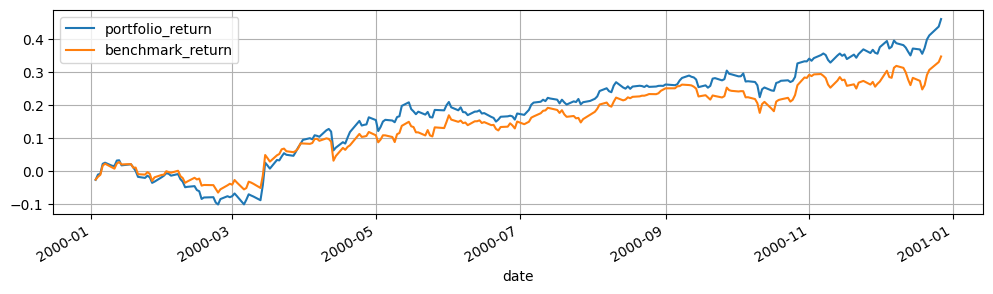

In [31]:
portfolio_performance = pd.DataFrame(pd.DataFrame(returns_df.values*weights_df.values, columns=weights_df.columns, index=weights_df.index).sum(axis=1),columns=['portfolio_return'])[:-2]
daily_returns = portfolio_performance.merge(bmrk,left_index=True,right_index=True,how='left')-1
cumulative_returns = ((daily_returns+1).cumprod()-1)
cumulative_returns.plot(figsize=(12,3))
plt.grid()


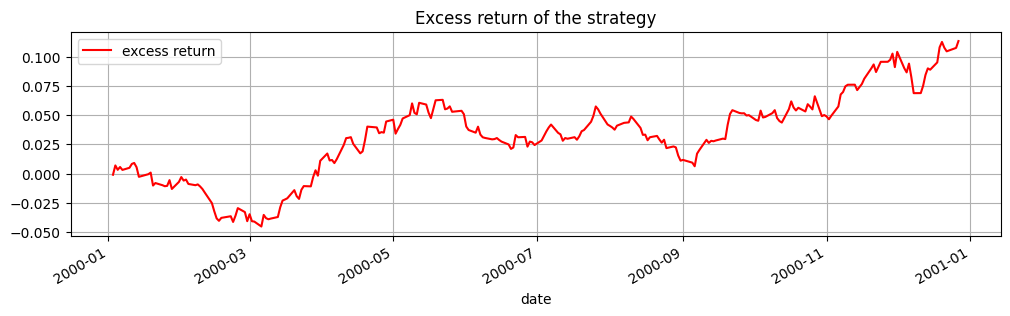

In [32]:
(cumulative_returns['portfolio_return']-cumulative_returns['benchmark_return']).plot(figsize=(12,3),label='excess return',color='r',legend=True)
plt.title('Excess return of the strategy')
plt.grid()


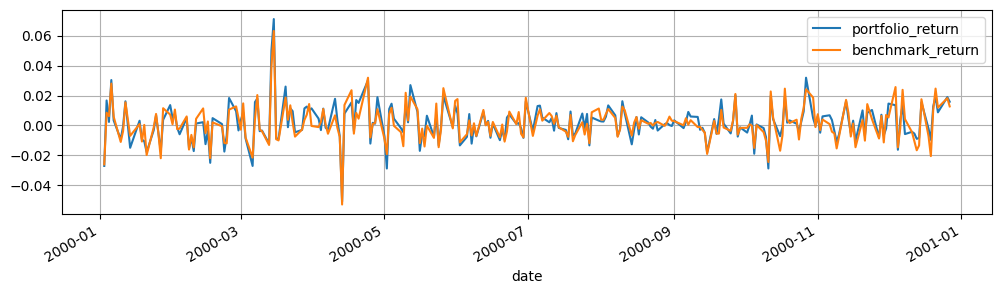

In [33]:
daily_returns.plot(figsize=(12,3))
plt.grid()


### Valeur ajoutée annualisée

In [34]:
annualized_return = (1+daily_returns).prod()**(252/len(daily_returns))-1
added_value_annualized = annualized_return['portfolio_return']-annualized_return['benchmark_return']
added_value_annualized


0.11449304271605265

### Risque actif annualisé

In [35]:
excess_return = daily_returns['portfolio_return']-daily_returns['benchmark_return']
active_risk_annualized = excess_return.std()*np.sqrt(252)
active_risk_annualized


0.07664589536862539

### Ratio d'information annualisé
C'est cette métrique qui est utilisée sur Kaggle

In [36]:
information_ratio_annualized = added_value_annualized/active_risk_annualized
information_ratio_annualized


1.49379222677748

### Pire rabattement relatif

In [37]:
max_seen_so_far = cumulative_returns.cummax()
drawdown = (cumulative_returns-max_seen_so_far)/max_seen_so_far
worst_drawdown = drawdown.min()
relative_worst_drawdown = worst_drawdown['portfolio_return']-worst_drawdown['benchmark_return']
relative_worst_drawdown


-0.7081102588085737

### Nombre de titres moyens

In [38]:
average_number_of_stocks = (weights_df>0).sum(axis=1).mean()
average_number_of_stocks


120.0

### Taux de roulement annuel

In [39]:
turnover_annual = (weights_df.diff().abs().sum(axis=1)/2).mean()*252
turnover_annual


6.6095293994496345

## Sanity check
Ces cellules vous permettent de voir si votre solution est conforme aux contraintes mentionnées dans l'énoncé ci-dessus.

In [40]:
for i,x in enumerate(weights_df.values):

    # Checks you respect the long-only and the cardinality constraint 
    n_positions = sum(x>.0000001)
    assert n_positions==0 or n_positions>=120

    # Checks you do not invest in non existing stocks
    assert (x[np.where(adjusted_close.loc[weights_df.index[i]].isna())]!=0.0).sum()==0
        